In [109]:
from os import listdir
import requests
import time
import tqdm
import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as VF
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt

In [6]:
open('facades', 'wb').write(requests.get('http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz').content)

5039

In [ ]:
with tarfile.open('facades') as arch:
  arch.extractall('./images')

In [110]:
def print_save_img(img, cnt):
  img = torch.cat((img[0], img[1], img[2]), -1)
  save_image(img, "images/%s.png" % ('facades_' + str(cnt)), nrow=5, normalize=True)
  mean = (0.5, 0.5, 0.5)
  std = (0.5, 0.5, 0.5)

  t_mean = torch.FloatTensor(mean).view(3,1,1).expand(3, 256, 256 * 3)
  t_std = torch.FloatTensor(std).view(3,1,1).expand(3, 256, 256 * 3)

  img_GT = img * t_std + t_mean

  img = transforms.ToPILImage()(img_GT).convert('RGB')
  resize = transforms.Resize(200)
  img = resize(img)
  display(img)

In [80]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder('train_images', transform=transform)
val_dataset = datasets.ImageFolder('validation_images', transform=transform)

In [81]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset))

In [ ]:
for batch in dataloader:
    break

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [75]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x


class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

  0%|          | 0/1 [00:00<?, ?it/s]

[Epoch 0/1] [Batch 399/400] [D loss: 0.286951] [G loss: 23.424391, pixel: 0.226284, adv: 0.795977]


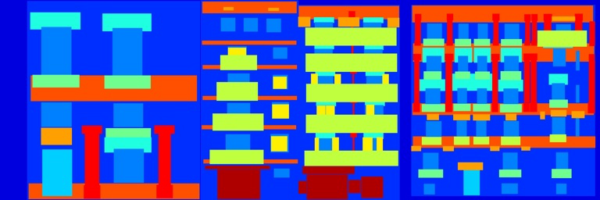

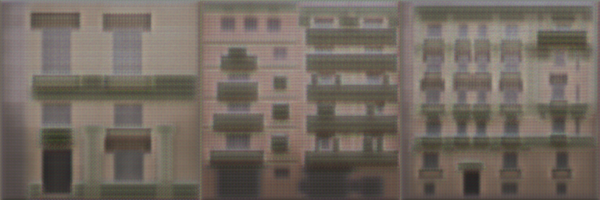

100%|██████████| 1/1 [13:52<00:00, 832.41s/it]


In [114]:
# Loss functions
criterion_GAN = torch.nn.MSELoss().to(device)
criterion_pixelwise = torch.nn.L1Loss().to(device)

# Calculate output of image discriminator (PatchGAN)
patch = (1, 16, 16)

# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

def set_requires_grad(net, req_grad):
    for param in net.parameters():
        param.requires_grad = req_grad

n_epochs = 1

for epoch in tqdm.tqdm(range(n_epochs)):
    for i, batch in enumerate(dataloader):

        # Model inputs
        real_A = batch[0][:, :, :, 256:]
        real_B = batch[0][:, :, :, :256]
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        # Adversarial ground truths
        valid = Variable(torch.tensor(np.ones((real_A.size(0), *patch)), dtype=torch.float), requires_grad=False)
        valid = valid.to(device)
        fake = Variable(torch.tensor(np.zeros((real_A.size(0), *patch)), dtype=torch.float), requires_grad=False)
        fake = fake.to(device)

        optimizer_G.zero_grad()

        # GAN loss
        fake_B = generator(real_A)
        pred_fake = discriminator(fake_B, real_A)
        loss_GAN = criterion_GAN(pred_fake, valid)
        # Pixel-wise loss
        loss_pixel = criterion_pixelwise(fake_B, real_B)

        # Total loss
        loss_G = loss_GAN + 100 * loss_pixel

        loss_G.backward()

        set_requires_grad(discriminator, False)
        optimizer_G.step()
        set_requires_grad(discriminator, True)

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_B, real_A)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach(), real_A)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        # Print log
    print(
        "\r[Epoch %d/%d] [D loss: %f] [G loss: %f, pixel: %f, adv: %f]"
        % (
            epoch,
            n_epochs,
            loss_D.item(),
            loss_G.item(),
            loss_pixel.item(),
            loss_GAN.item(),
        )
        )

    # If at sample interval save image
    if epoch % 10 == 0:
      imgs = next(iter(val_dataloader))
      ix = np.random.randint(0, len(val_dataset), 3).tolist()
      real_A = imgs[0][ix, :, :, 256:]
      real_B = imgs[0][ix, :, :, :256]
      fake_B = generator(real_A)
      print_save_img(real_B, epoch // 10)
      print_save_img(fake_B, epoch // 10)
      torch.save(generator.state_dict(), 'generator_' + str(epoch // 10))